In [1]:
import glob
import matplotlib.pyplot as plt
import xarray as xr
import os
import calendar
import pandas as pd
import datetime as dt
# import gcsfs
import geopandas as gpd
import rioxarray as rxr

c:\Users\LENOVO\anaconda3\envs\hydromt\Lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20920\3090486284.py:9: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. Ho

In [8]:
onedrive_path = 'C:/Users/LENOVO/OneDrive/Work/Python/DataAnalysis/DataAnalysis/Data/spatial-data/'
local_path = 'D:/ERA5_Data/Pakistan/'

In [9]:
# Read the shapefile using geopandas
gdf = gpd.read_file(onedrive_path+'/Shapefiles/Pakistan.shp')

#Reading the nc file
nc_file  = xr.open_dataset(local_path+'/ppt4.nc')
nc_file = nc_file.drop_vars('expver')
tp_removed_dim = nc_file['tp'].isel(expver=0)
nc_file['tp'] = tp_removed_dim

In [10]:
nc_file

<xarray.Dataset>
Dimensions:    (longitude: 68, latitude: 54, time: 92437)
Coordinates:
  * longitude  (longitude) float32 60.89 61.14 61.39 61.64 ... 77.14 77.39 77.64
  * latitude   (latitude) float32 36.95 36.7 36.45 36.2 ... 24.2 23.95 23.7
  * time       (time) datetime64[ns] 2013-01-01 ... 2023-07-19T12:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-24 14:36:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
 # Set the CRS information for the NetCDF file
nc_file.rio.write_crs(gdf.crs, inplace=True)

# Clip the NetCDF file using the shapefile's geometry
clipped_ds = nc_file.rio.clip(gdf.geometry, gdf.crs)

In [12]:
filtered_data = clipped_ds.sel(time=slice("2022-01-01", "2022-12-31"))
filtered_data

<xarray.Dataset>
Dimensions:      (longitude: 67, latitude: 53, time: 8760)
Coordinates:
  * longitude    (longitude) float32 61.14 61.39 61.64 ... 77.14 77.39 77.64
  * latitude     (latitude) float32 36.95 36.7 36.45 36.2 ... 24.45 24.2 23.95
  * time         (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
    spatial_ref  int32 0
Data variables:
    tp           (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-24 14:36:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [13]:
filtered_data = filtered_data.drop_vars('spatial_ref')

In [14]:
ds_mon = filtered_data.resample(time='M').sum(skipna=True)
ds_mon *= 1000
# ds22_mon.tp[6,:,:].plot(cmap='jet', vmax=400)

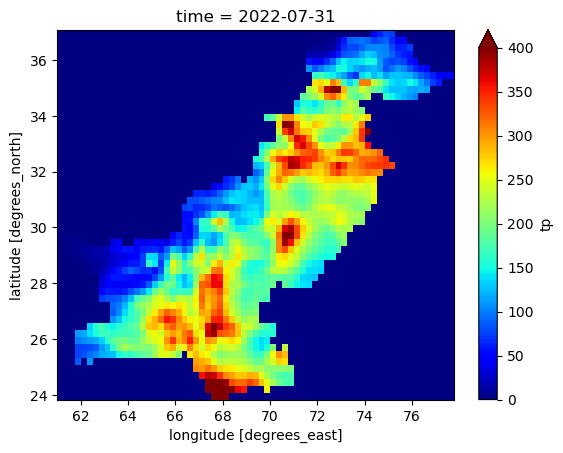

In [15]:
ds_mon.tp[6,:,:].plot(cmap='jet', vmax=400)

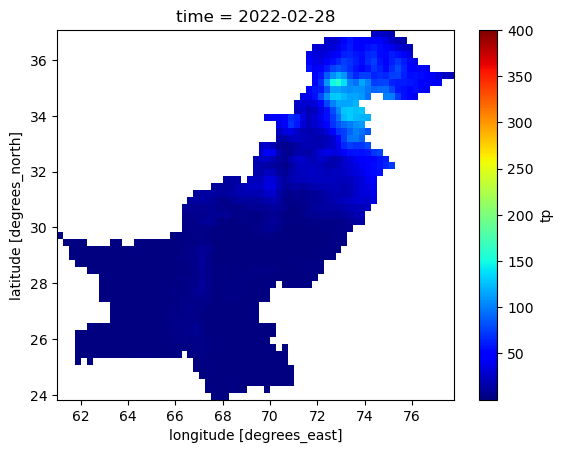

In [16]:
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = ds_mon['tp'].sum(dim='time')>0
data_edited = ds_mon['tp'].where(landmask)
data_edited[1,:,:].plot(cmap='jet', vmax=400)

Text(1, 0.03, 'Year =12 ')

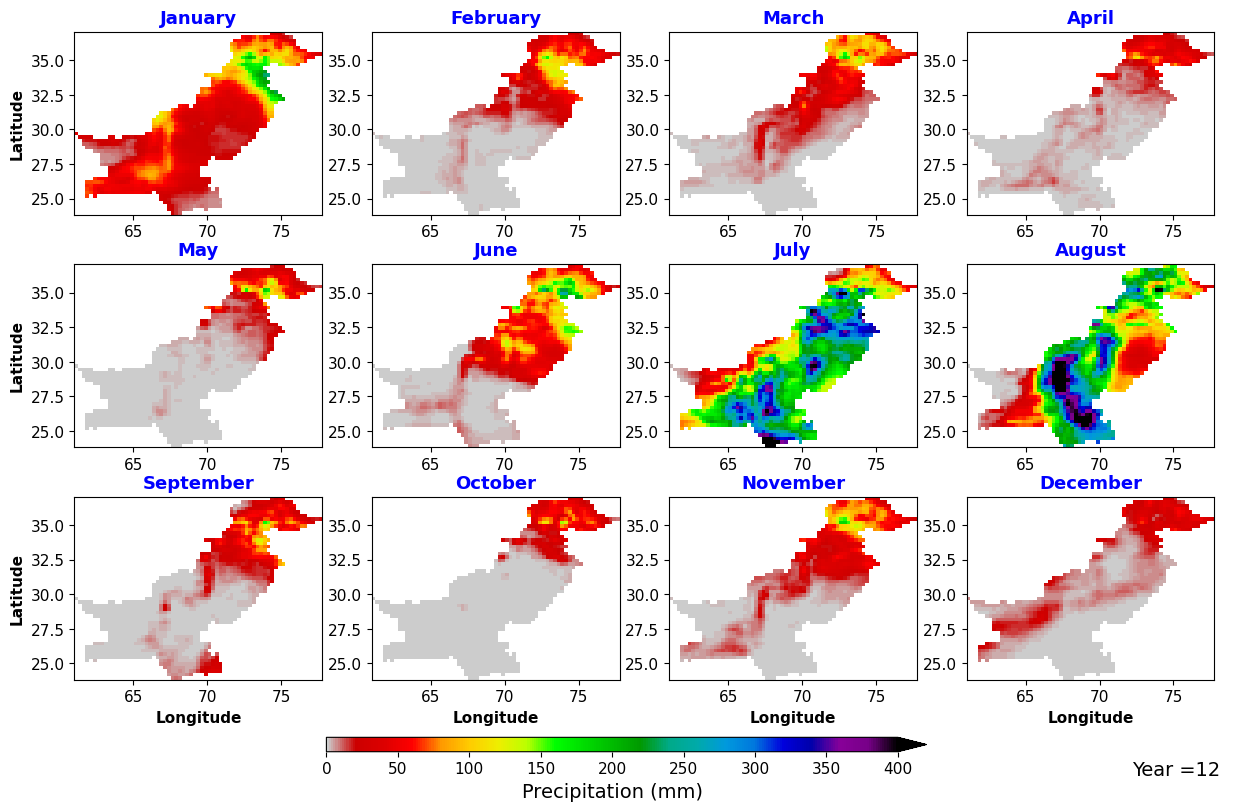

In [19]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
# plt.title('Monthly Precipitation sum for USA-2022')


for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = data_edited[i-1, :, :].where(landmask) # Remember that in Python, the data index starts at 0, but the subplot index start at 1.
    p = plt.pcolormesh(dataplot.longitude, dataplot.latitude, dataplot,
                   vmax = 400, vmin = 0, cmap = 'nipy_spectral_r',
                   ) 
    # plt.xlim([230,300])
    # plt.ylim([20,50])
    plt.title(calendar.month_name[i], fontsize = 13, 
              fontweight = 'bold', color = 'b')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color = 'k', size=14)
fig.text(1, 0.03, f'Year ={i} ', fontsize=14, ha='right')


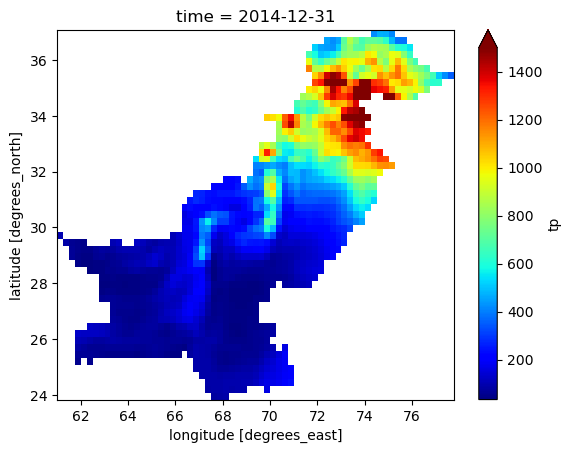

In [205]:
ds_year = clipped_ds.resample(time='Y').sum(skipna=True)
ds_year *= 1000
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask_year = ds_year['tp'].sum(dim='time')>0
data_edited_year = ds_year['tp'].where(landmask_year)
data_edited_year = data_edited_year.drop_vars('spatial_ref')
data_edited_year[1,:,:].plot(cmap='jet', vmax=1500)
# data_edited_year

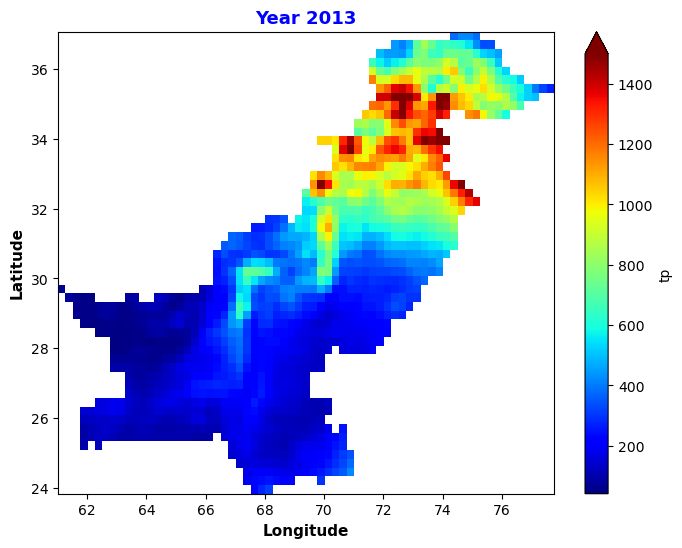

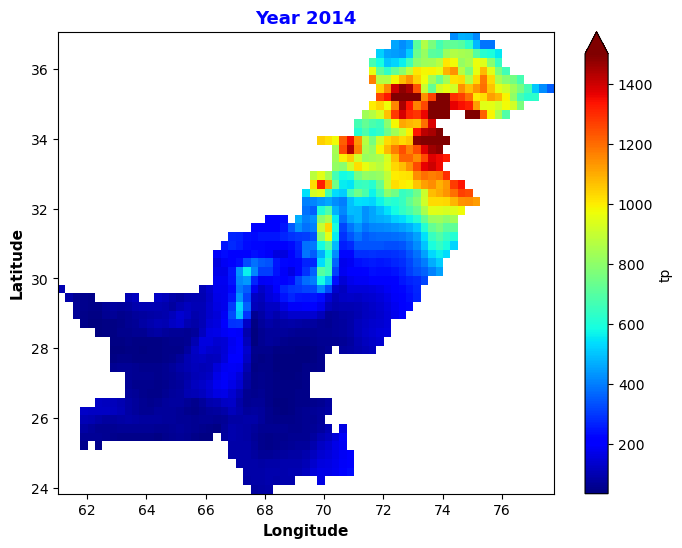

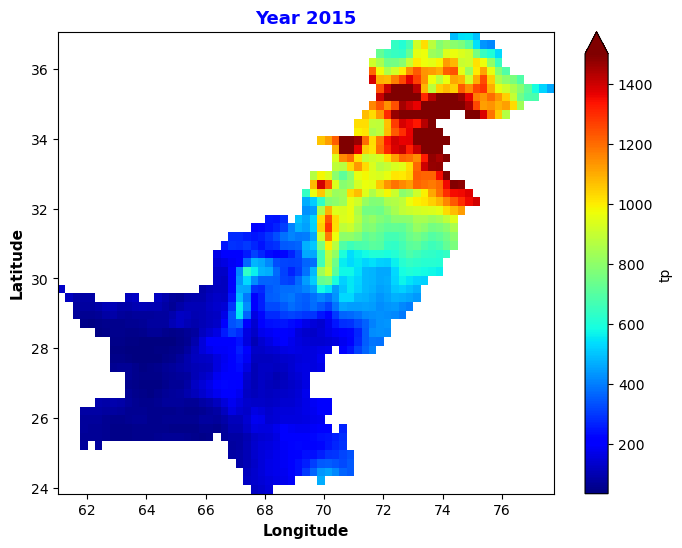

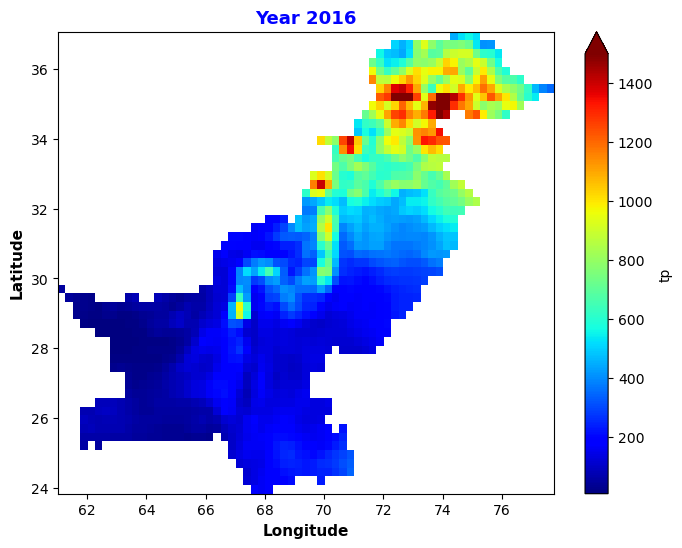

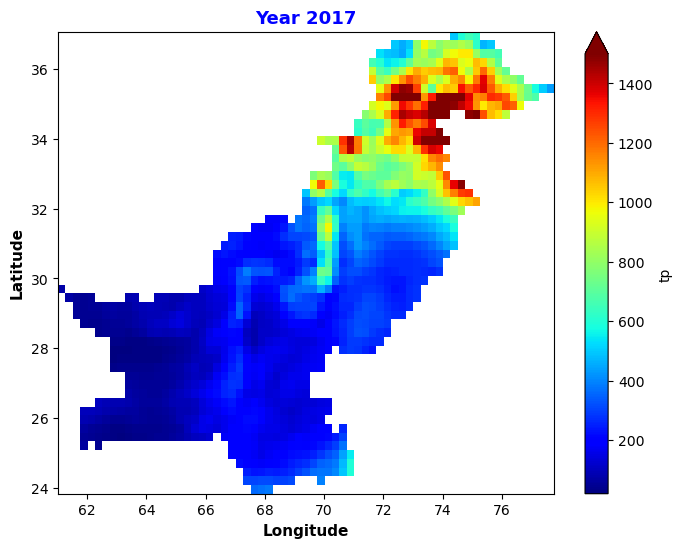

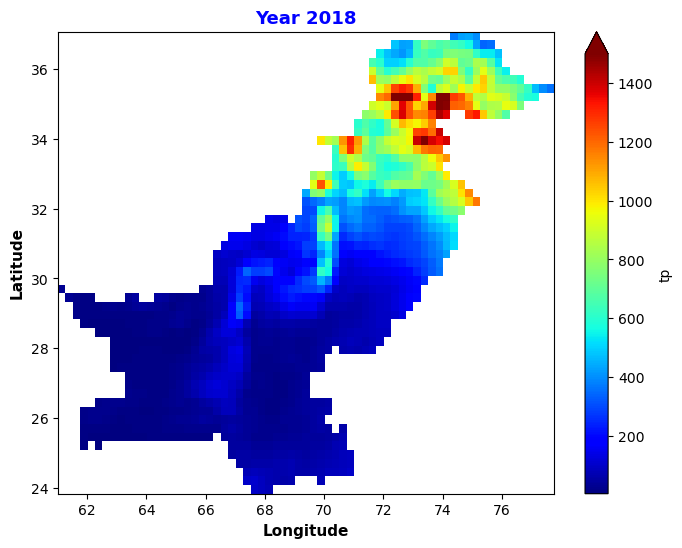

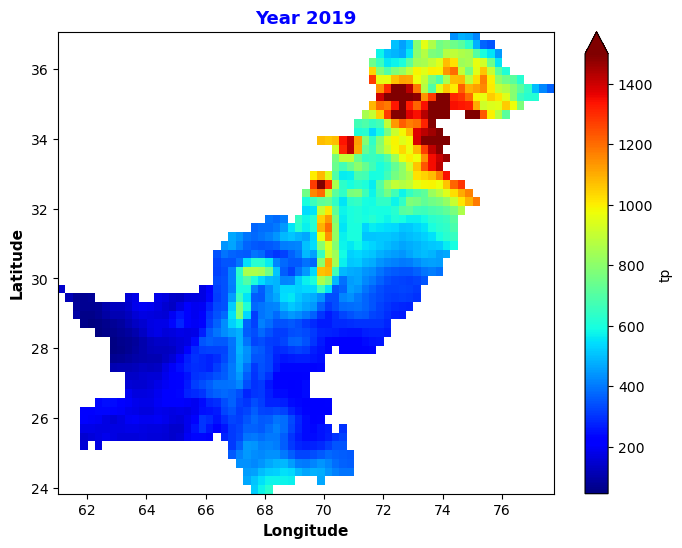

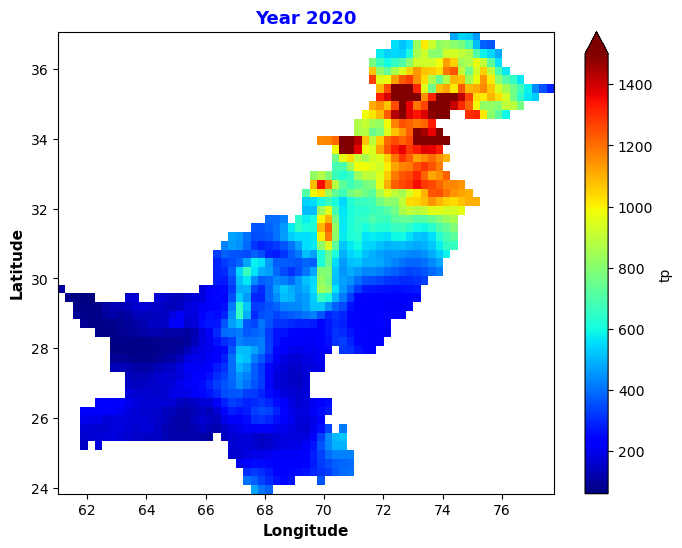

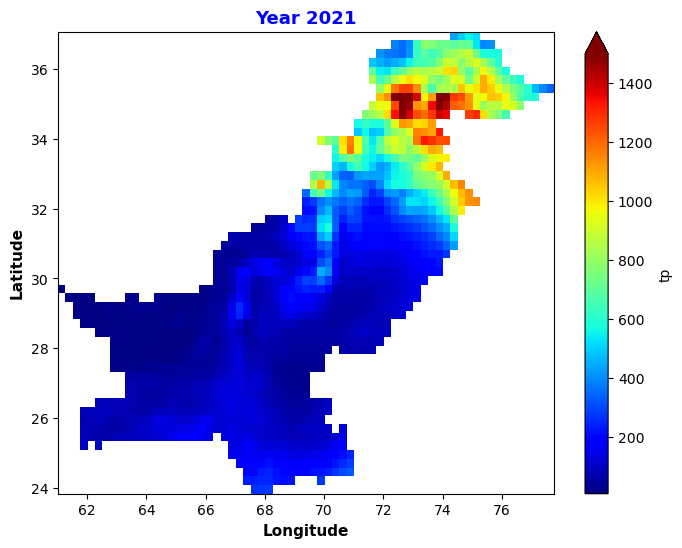

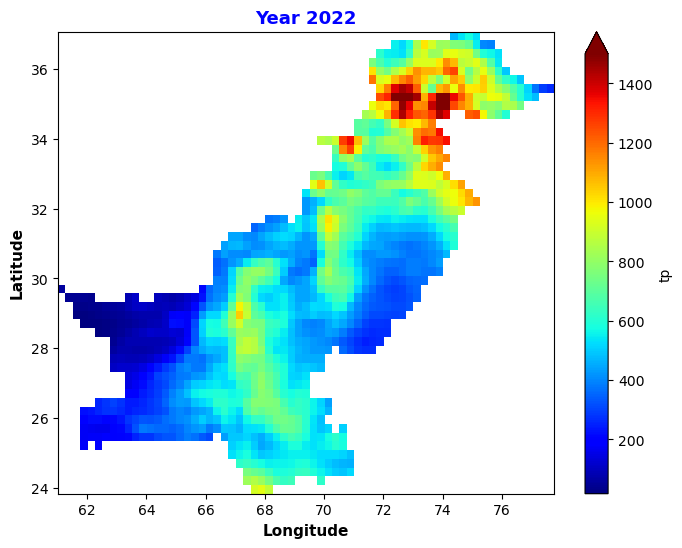

In [208]:
for year in range(2013, 2023):
    # Select data for the current year
    data_edited_year = ds_year['tp'].where(landmask_year).sel(time=str(year))

    # Create a subplot
    plt.figure(figsize=(8, 6))
    # plt.subplot(1, 1, 1)  # You can adjust the subplot layout as needed

    # Plot the data for the current year
    p = data_edited_year.plot(cmap='jet', vmax=1500)

    # Customize subplot title and labels as needed
    plt.title(f'Year {year}', fontsize=13, fontweight='bold', color='b')
    plt.xlabel('Longitude', fontsize=11, fontweight='bold')
    plt.ylabel('Latitude', fontsize=11, fontweight='bold')

    # Add colorbar
    # cbar = plt.colorbar(p, shrink=0.75, label='Precipitation (mm)')
    # Save or show the subplot
    plt.savefig(onedrive_path+f'year_{year}_plot.png')  # Save the plot as an image file
    # plt.show()
